# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.cuda.amp import autocast
from torch.nn.parallel import DataParallel
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import LambdaLR
# from torch.utils.tensorboard import SummaryWriter
from advertorch.attacks import GradientSignAttack

In [3]:
from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage, Ratio
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, ZipCycle, track_maximum, save_source_as_img
from SSL.util.model_loader import load_model
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser

from SSL.ramps import Warmup, sigmoid_rampup
from SSL.losses import loss_cot, loss_diff, loss_sup, JensenShanon, js_from_softmax, loss_diff_simple

In [4]:
a = torch.randn((1, 5))
b = torch.randn((1, 5))

S = nn.Softmax(dim=1)
LS = nn.LogSoftmax(dim=1)
S(a), S(b), S(a) * LS(b)

(tensor([[0.0767, 0.4769, 0.1420, 0.2091, 0.0953]]),
 tensor([[0.1882, 0.4440, 0.0470, 0.0916, 0.2292]]),
 tensor([[-0.1281, -0.3872, -0.4340, -0.5000, -0.1404]]))

# Arguments

In [5]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../../datasets/", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str)

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("--model", default="wideresnet28_2", type=str)
group_t.add_argument("--supervised_ratio", default=0.1, type=float)
group_t.add_argument("--batch_size", default=100, type=int)
group_t.add_argument("--nb_epoch", default=300, type=int)
group_t.add_argument("--learning_rate", default=5e-4, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("ESC and UBS8K parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_h = parser.add_argument_group('hyperparameters')
group_h.add_argument("--lambda_cot_max", default=1, type=float)
group_h.add_argument("--lambda_diff_max", default=0.5, type=float)
group_h.add_argument("--warmup_length", default=160, type=int)
group_h.add_argument("--fusion_method", default="geometric_mean")
group_h.add_argument("--epsilon", default=0.02, type=float)

group_h.add_argument("--ema_alpha", default=0.999, type=float)
group_h.add_argument("--teacher_noise", default=0, type=float)
group_h.add_argument("--lambda_ccost_max", default=1, type=float)
group_h.add_argument("--ccost_method", default="mse", type=str)
group_h.add_argument("--ccost_softmax", action="store_false", default=True)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="deep-co-training_teacher4", type=str)
group_l.add_argument("--tensorboard_path", default="deep-co-training_teacher4", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

## Basic verification

In [6]:
available_datasets = ["esc10", "ubs8k", "speechcommand"]
available_models = ["cnn03", "wideresnet28_2", "wideresnet28_4", "wideresnet28_8"]
available_ccost_method = ["mse", "js"]

assert args.dataset in available_datasets
assert args.model in available_models
assert args.ccost_method in available_ccost_method

# Initialization

In [7]:
reset_seed(args.seed)

# Prepare the dataset

In [8]:
train_transform, val_transform = load_preprocesser(args.dataset, "dct")

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [9]:
train_transform

Sequential(
  (0): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (1): AmplitudeToDB()
)

In [10]:
manager, train_loader, val_loader = load_dataset(
    args.dataset,
    "mean-teacher",
    
    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,

    train_transform=train_transform,
    val_transform=val_transform,
    
    num_workers=2,
    pin_memory=True,

    verbose = 2
)

Dataset already downloaded and verified.
Dataset already downloaded and verified.
s_batch_size:  10
u_batch_size:  90


In [11]:
input_shape = train_loader._iterables[0].dataset[0][0].shape
input_shape

torch.Size([64, 431])

# Models

In [12]:
torch.cuda.empty_cache()
model_func = load_model(args.dataset, args.model)

commun_args = dict(
    manager=manager,
    num_classes=args.num_classes,
    input_shape=list(input_shape),
)

m1 = model_func(**commun_args)
# m2 = model_func(**commun_args)

# m1 = DataParallel(m1)
# m2 = DataParallel(m2)

m1 = m1.cuda()
# m2 = m2.cuda()

# Create teacher model a remove it from the gradient graph
teacher = model_func(**commun_args)
teacher = teacher.cuda()
for p in teacher.parameters():
    p.detach()

RuntimeError: CUDA error: out of memory

In [ ]:
from torchsummary import summary

s = summary(m1, tuple(input_shape))


# training parameters

In [ ]:
# tensorboard
tensorboard_title = f"{args.model}/{args.supervised_ratio}S/" \
                    f"{get_datetime()}_{model_func.__name__}_teacher_" \
                    f"{args.fusion_method}-fusion_{args.ema_alpha}a_{args.teacher_noise}n"
checkpoint_title = f"{args.model}/{args.supervised_ratio}S/" \
                   f"{args.model}_teacher_" \
                   f"{args.fusion_method}-fusion_{args.ema_alpha}a_{args.teacher_noise}n"

tensorboard = mSummaryWriter(log_dir=f"{tensorboard_path}/{tensorboard_title}",comment=model_func.__name__)
print(os.path.join(tensorboard_path, tensorboard_title))

## Optimizer & callbacks

In [ ]:
optim_args = dict(
    learning_rate=args.learning_rate,
)

optimizer = load_optimizer(args.dataset, "mean-teacher", student=m1, **optim_args)
callbacks = load_callbacks(args.dataset, "mean-teacher", optimizer=optimizer, nb_epoch=args.nb_epoch)


## Adversarial generator

In [ ]:
# adversarial generation
adv_generator_1 = GradientSignAttack(
    teacher, loss_fn=nn.CrossEntropyLoss(reduction="sum"),
    eps=args.epsilon, clip_min=-np.inf, clip_max=np.inf, targeted=False
)

In [ ]:
# Losses
# see losses.py
loss_diff = nn.CrossEntropyLoss(reduction="mean")
loss_sup = nn.CrossEntropyLoss(reduction="mean")

if args.ccost_method == "mse":
    consistency_cost = nn.MSELoss(reduction="mean") # Unsupervised loss
elif args.ccost_method == "js":
    consistency_cost = js_from_softmax

# define the warmups & add them to the callbacks (for update)
lambda_cot = Warmup(args.lambda_cot_max, args.warmup_length, sigmoid_rampup)
lambda_diff = Warmup(args.lambda_diff_max, args.warmup_length, sigmoid_rampup)
lambda_ccost = Warmup(args.lambda_ccost_max, args.warmup_length, sigmoid_rampup)
callbacks += [lambda_cot, lambda_diff, lambda_ccost]

# checkpoints
checkpoint = CheckPoint([m1, teacher], optimizer, mode="max", name="%s/%s_m1.torch" % (checkpoint_path, checkpoint_title))

## Metrics and hyperparameters

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
# metrics
metrics_fn = dict(
    # ratio_s=[Ratio(), Ratio()],
    # ratio_u=[Ratio(), Ratio()],
    acc_s=[CategoricalAccuracy(), CategoricalAccuracy()],
    acc_u=[CategoricalAccuracy(), CategoricalAccuracy()],
    acc_t=[CategoricalAccuracy(), CategoricalAccuracy()],
    acc_f=CategoricalAccuracy(),
    f1_s=[FScore(), FScore()],
    f1_u=[FScore(), FScore()],
    
    avg_total=ContinueAverage(),
    avg_sup=ContinueAverage(),
    avg_cot=ContinueAverage(),
    avg_diff=ContinueAverage(),
    avg_teacher=ContinueAverage(),
)

maximum_tracker = track_maximum()

softmax_fn = lambda x: x
if args.ccost_softmax:
    softmax_fn = nn.Softmax(dim=1)


def reset_metrics():
    for item in metrics_fn.values():
        if isinstance(item, list):
            for f in item:
                f.reset()
        else:
            item.reset()

reset_metrics()

# Training functions

In [ ]:
UNDERLINE_SEQ = "\033[1;4m"
RESET_SEQ = "\033[0m"

header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} | {:<6.6} | {:<6.6} | {:<6.6} - {:<9.9} {:<9.9} | {:<9.9} | {:<9.9} | {:<9.9} - {:<6.6}"
value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} | {:<6.4f} | {:<6.4f} | {:<6.4f}- {:<9.9} {:<9.4f} | {:<9.4f} | {:<9.4f} | {:<9.4f} - {:<6.4f}"

header = header_form.format(
    "", "Epoch", "%", "Losses:", "Lsup", "Ldiff", "Lteacher", "total", "metrics: ", "acc_s1", "acc_u1", "acc_ts", "acc_tu", "Time"
)

train_form = value_form
val_form = train_form #UNDERLINE_SEQ + value_form + RESET_SEQ

print(header)

In [ ]:
def update_teacher_model(student_model, teacher_model, alpha, epoch):
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (epoch + 1), alpha)
    
    for param, ema_param in zip(student_model.parameters(), teacher_model.parameters()):
        ema_param.data.mul_(alpha).add_(param.data,  alpha = 1-alpha)

noise_fn = lambda x: x
if args.teacher_noise != 0:
    n_db = args.teacher_noise
    noise_fn = transforms.Lambda(lambda x: x + (torch.rand(x.shape).cuda() * n_db + n_db))

def arithmetric_avg(a, b):
    return (a + b) / 2

def geometric_avg(a, b):
    # in log space to avoid overflow
    log_a, log_b = torch.log(a), torch.log(b)
    return torch.exp((log_a + log_b) / 2)

def harmonic_avg(a, b):
    return 2 / (1/a + 1/b)

def get_fusion_method(method: str):
    if method == "m1":
        return lambda x, y: x
    elif method == "m2":
        return lambda x, y: y
    elif method == "arithmetic_mean":
        return arithmetric_avg
    elif method == "geometric_mean":
        return geometric_avg
    elif method == "harmonic_mean":
        return harmonic_avg
    else:
        raise ValueError("method %s doesn't exist for fusion")

fusion_fn = get_fusion_method(args.fusion_method)


a = torch.randn((64, 10))
b = torch.randn((64, 10))

pred = torch.argmax(b, dim=1)

S = nn.Softmax(dim=1)
LS = nn.LogSoftmax(dim=1)

ce = nn.CrossEntropyLoss (reduction="mean")

def m_ce(x, y):
    a = LS(x) * S(y)
    return - torch.sum(a) / x.size()[0]

print(ce(a, pred))
print(m_ce(a, b))

In [ ]:
nb_batch = len(train_loader)
def train(epoch):
    start_time = time.time()
    print("")

    reset_metrics()
    m1.train()

    for batch, (S, U) in enumerate(train_loader):
        x_s, y_s = S
        x_u, y_u = U
        
        x_s, x_u = x_s.cuda(), x_u.cuda()
        y_s, y_u = y_s.cuda(), y_u.cuda()

        with autocast():
            logits_s = m1(x_s)
            logits_u = m1(x_u)

            logits_ts = teacher(noise_fn(x_s))
            logits_tu = teacher(noise_fn(x_u))

        # pseudo labels of U
        pred_u = torch.argmax(logits_u, 1)

        # ======== Generate adversarial examples ========
        #generate adversarial examples ----
        adv_data_ts = adv_generator_1.perturb(x_s, y_s)
        adv_data_tu = adv_generator_1.perturb(x_u, pred_u)

        # predict adversarial examples ----
        with autocast():
            adv_logits_ts = m1(adv_data_ts)
            adv_logits_tu = m1(adv_data_tu)

        # ======== calculate the differents loss ========
        # zero the parameter gradients ----
        for p in m1.parameters(): p.grad = None  # zero grad

        # losses ----
        with autocast():
            l_sup = loss_sup(
                fusion_fn(softmax_fn(logits_s), softmax_fn(logits_ts)),
                y_s
            )

            # l_cot = loss_cot(logits_u1, logits_u2)

            l_diff = loss_diff_simple(logits_s, adv_logits_ts, logits_u, adv_logits_tu)

            # logits_student_u = logits_u1
            l_teacher = consistency_cost(softmax_fn(logits_s), softmax_fn(logits_ts))
            l_teacher += consistency_cost(softmax_fn(logits_u), softmax_fn(logits_tu))

            total_loss = l_sup + lambda_diff() * l_diff + lambda_ccost() * l_teacher

        total_loss.backward()
        optimizer.step()

        # ======== Calc the metrics ========
        with torch.set_grad_enabled(False):
            # predict logits teacher on S1, for monitoring purpose
            logits_ts = teacher(x_s)

            # Update teacher
            update_teacher_model(m1, teacher, args.ema_alpha, epoch*nb_batch + batch)

            # accuracies ----
            pred_s = torch.argmax(logits_s, dim=1)
            # pred_s2 = torch.argmax(logits_s2, dim=1)
            pred_t1 = torch.argmax(logits_ts, dim=1)
            pred_tu = torch.argmax(logits_tu, dim=1)
            pred_ts = torch.argmax(logits_ts, dim=1)

            acc_s1 = metrics_fn["acc_s"][0](pred_s, y_s)
            # acc_s2 = metrics_fn["acc_s"][1](pred_s2, y_s)
            acc_u1 = metrics_fn["acc_u"][0](pred_u, y_u)
            # acc_u2 = metrics_fn["acc_u"][1](pred_u2, y_u)
            acc_t1 = metrics_fn["acc_t"][0](pred_ts, y_s)
            acc_tu = metrics_fn["acc_t"][1](pred_tu, y_u)

            # ratios  ----
            # adv_pred_s1 = torch.argmax(adv_logits_s1, 1)
            # adv_pred_s2 = torch.argmax(adv_logits_s2, 1)
            # adv_pred_u1 = torch.argmax(adv_logits_u1, 1)
            # adv_pred_u2 = torch.argmax(adv_logits_u2, 1)

            # ratio_s1 = metrics_fn["ratio_s"][0](adv_pred_s1, y_s)
            # ratio_s2 = metrics_fn["ratio_s"][0](adv_pred_s2, y_s)
            # ratio_u1 = metrics_fn["ratio_s"][0](adv_pred_u1, y_u)
            # ratio_u2 = metrics_fn["ratio_s"][0](adv_pred_u2, y_u)
            # ========

            avg_total = metrics_fn["avg_total"](total_loss.item())
            avg_sup = metrics_fn["avg_sup"](l_sup.item())
            avg_diff = metrics_fn["avg_diff"](l_diff.item())
            # avg_cot = metrics_fn["avg_cot"](l_cot.item())
            avg_teacher = metrics_fn["avg_teacher"](l_teacher.item())

            # logs
            print(train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (batch + 1) / len(train_loader)),
                "", avg_sup.mean, avg_diff.mean, avg_teacher.mean, avg_total.mean,
                "", acc_s1.mean, acc_u1.mean, acc_t1.mean, acc_tu.mean,
                time.time() - start_time
            ), end="\r")


    # using tensorboard to monitor loss and acc\n",
    tensorboard.add_scalar('train/total_loss', avg_total.mean, epoch)
    tensorboard.add_scalar('train/Lsup', avg_sup.mean, epoch )
    # tensorboard.add_scalar('train/Lcot', avg_cot.mean, epoch )
    tensorboard.add_scalar('train/Ldiff', avg_diff.mean, epoch )
    tensorboard.add_scalar('train/Lteacher', avg_teacher.mean, epoch )
    tensorboard.add_scalar("train/acc_1", acc_s1.mean, epoch )
    # tensorboard.add_scalar("train/acc_2", acc_s2.mean, epoch )

    tensorboard.add_scalar("detail_acc/acc_s1", acc_s1.mean, epoch)
    # tensorboard.add_scalar("detail_acc/acc_s2", acc_s2.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_u1", acc_u1.mean, epoch)
    # tensorboard.add_scalar("detail_acc/acc_u2", acc_u2.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_t1", acc_t1.mean, epoch)
    tensorboard.add_scalar("detail_acc/acc_tu", acc_tu.mean, epoch)

    # tensorboard.add_scalar("detail_ratio/ratio_s1", ratio_s1.mean, epoch)
    # tensorboard.add_scalar("detail_ratio/ratio_s2", ratio_s2.mean, epoch)
    # tensorboard.add_scalar("detail_ratio/ratio_u1", ratio_u1.mean, epoch)
    # tensorboard.add_scalar("detail_ratio/ratio_u2", ratio_u2.mean, epoch)

    # Return the total loss to check for NaN
    return total_loss.item()

In [ ]:
def test(epoch, msg = ""):
    start_time = time.time()
    print("")

    reset_metrics()
    m1.eval()

    with torch.set_grad_enabled(False):
        for batch, (X, y) in enumerate(val_loader):
            x = X.cuda()
            y = y.cuda()

            with autocast():
                logits_1 = m1(x)
                logits_t = teacher(x)

                # losses ----
                l_sup = loss_sup(logits_1, y)

            # ======== Calc the metrics ========
            # accuracies ----
            pred_1 = torch.argmax(logits_1, dim=1)
            pred_t = torch.argmax(logits_t, dim=1)

            acc_1 = metrics_fn["acc_s"][0](pred_1, y)
            acc_t = metrics_fn["acc_t"][0](pred_t, y)

            avg_sup = metrics_fn["avg_sup"](l_sup.item())

            # logs
            print(val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (batch + 1) / len(train_loader)),
                "", avg_sup.mean, 0.0, 0.0, avg_sup.mean,
                "", acc_1.mean, 0.0, acc_t.mean, 0.0,
                time.time() - start_time
            ), end="\n")

    tensorboard.add_scalar("val/acc_1", acc_1.mean, epoch)
    tensorboard.add_scalar("val/acc_t", acc_t.mean, epoch)
        
    tensorboard.add_scalar("max/acc_1", maximum_tracker("acc_1", acc_1.mean), epoch )
    tensorboard.add_scalar("max/acc_t", maximum_tracker("acc_t", acc_t.mean), epoch )
    
    tensorboard.add_scalar("detail_hyperparameters/lambda_cot", lambda_cot(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/lambda_diff", lambda_diff(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/lambda_ccost", lambda_ccost(), epoch)
    tensorboard.add_scalar("detail_hyperparameters/learning_rate", get_lr(optimizer), epoch)

    # Apply callbacks
    for c in callbacks:
        c.step()

    # call checkpoint
    checkpoint.step(acc_1.mean)


In [ ]:
# can resume training
if args.resume:
    checkpoint.load_last()
start_epoch = checkpoint.epoch_counter

print(header)
for epoch in range(start_epoch, args.nb_epoch):
    total_loss = train(epoch)
    
    if np.isnan(total_loss):
        print("Losses are NaN, stoping the training here")
        break
        
    test(epoch)

    tensorboard.flush()

In [84]:
hparams = {}
for key, value in args.__dict__.items():
    hparams[key] = str(value)

final_metrics = {
    "max_acc_1": maximum_tracker.max["acc_1"],
    # "max_acc_2": maximum_tracker.max["acc_2"],
    "max_acc_t": maximum_tracker.max["acc_t"],
    # "max_acc_f12": maximum_tracker.max["acc_f12"],
}
tensorboard.add_hparams(hparams, final_metrics)
tensorboard.flush()

# source_code_path = "co-training_teacher_m1.ipynb"
# source_code_img, padding_size = save_source_as_img(source_code_path)
# tensorboard.add_image("source_code_path___%s" % padding_size, source_code_img , 0, dataformats="HW")

tensorboard.flush()
tensorboard.close()

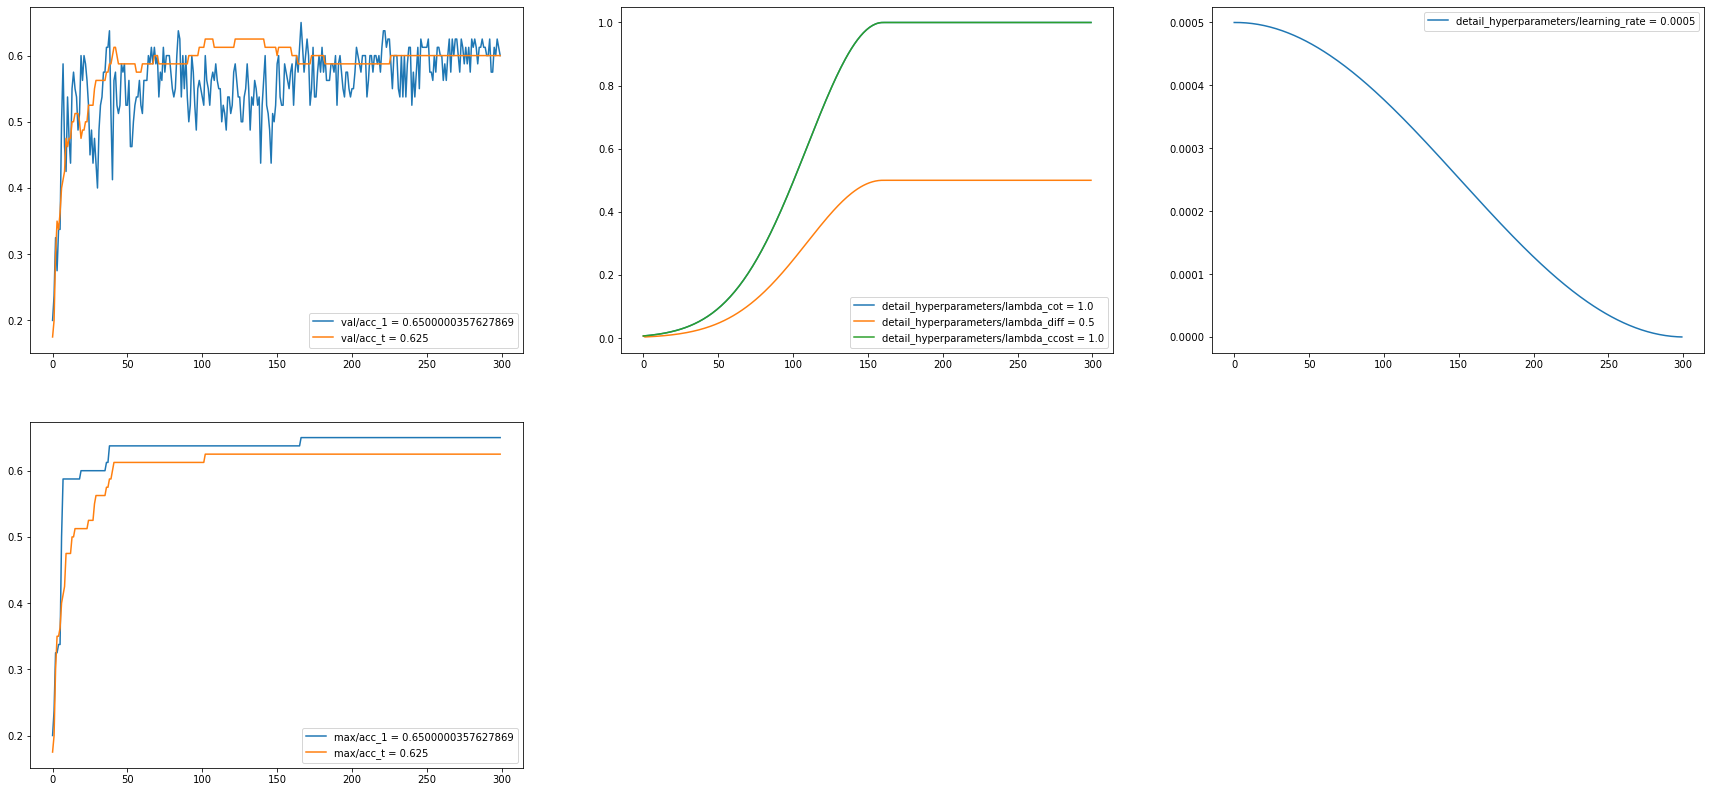

In [85]:
import matplotlib.pyplot as plt

x = list(range(checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, tensorboard.history[k], label=f"{k} = {max(tensorboard.history[k])}")
spp = lambda k: plt.plot(x, sm(tensorboard.history[k], 5), label=f"{k} = {max(tensorboard.history[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
pp("val/acc_1")
# pp("val/acc_2")
pp("val/acc_t")
# pp("val/acc_f12")
plt.legend()

plt.subplot(2, 3, 2)
pp("detail_hyperparameters/lambda_cot")
pp("detail_hyperparameters/lambda_diff")
pp("detail_hyperparameters/lambda_ccost")
plt.legend()

plt.subplot(2, 3, 3)
pp("detail_hyperparameters/learning_rate")
plt.legend()

plt.subplot(2, 3, 4)
pp("max/acc_1")
# pp("max/acc_2")
pp("max/acc_t")
# pp("max/acc_f12")
plt.legend()

plt.show()